# Image classification with neural networks

In this problem, you will train a neural network to classify satellite images. In the `data/EuroSAT_RGB` directory, you will find 11 subdirectories, each corresponding to a different class of land or land use: e.g. industrial, crops, rivers, forest, etc. Within each subdirectory, you will find examples in .jpg format of each type. (Thus the name of the directory in which the image lives is the class label.)

Your job is to set up a neural network that can classify the images as accurately as possible. Use an 80/20 train test split. Summarize your model and its accuracy in any way you see fit, but make you include at a minimum the following elements:

* overall test-set accuracy, measured however you think is appropriate
* show some of the example images from the test set, together with your model's predicted classes.
* a confusion matrix showing the performance of the model on the set test, i.e. a table that cross-tabulates each test set example by (actual class, predicted class).

I strongly recommend the use of PyTorch in a Jupyter notebook for this problem; look into PyTorch's ImageFolder data set class, which will streamline things considerably.

In [1]:
#Importing the required modules for building and training neural networks, handling datasets, calculating metrics, and visualization.
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim
import tqdm
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
# Load the EuroSAT_RGB dataset and create data loaders
data_dir = 'C:/Users/krish/Downloads/STA380-master/data/EuroSAT_RGB'

transform = transforms.Compose([
                                transforms.Resize((64, 64)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])

# Create an ImageFolder dataset
dataset = ImageFolder(data_dir, transform = transform)

# Split the dataset into 80/20 train and test sets
train_ratio = 0.8  # You can adjust the train-test split ratio
train_size = int(train_ratio * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = 64, shuffle = True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = 64, shuffle = False)

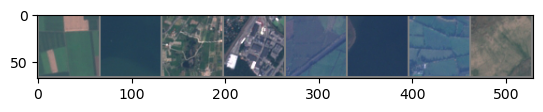

Sample Labels: AnnualCrop SeaLake PermanentCrop Industrial Highway SeaLake Pasture HerbaceousVegetation


In [3]:
# Function to display a sample of images
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get a batch of training images and display them
dataiter = iter(train_loader)
images, labels = dataiter.__next__()

imshow(torchvision.utils.make_grid(images[:8]))
sample_labels = [dataset.classes[idx] for idx in labels[:8]]
print('Sample Labels:', ' '.join(sample_labels))

In [4]:
# Let's define a simple CNN to classify images

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, 3, 1)  # in_channels, out_channels, kernel_size, stride
        self.conv2 = nn.Conv2d(64, 128, 3, 1)
        self.dropout1 = nn.Dropout(0.25)  # Each channel gets zeroed out independently on each forward call with probability p
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(115200, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

net = Net()
print(net)

Net(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout(p=0.25, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=115200, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


We have decided to use the simple neural network with two convolutional layers, two dropout layers and two fully connected layers as discussed in class. However, we changed the output channels for each convolutional layers a few times to check the overall accuracy of the model. We got better accuracy for 64 and 128 output channels for convolutional layer 1 and convolutional layer 2 respectively. We observed that as we increase the number of output channels for each convolutional layer, the time taken to run the model increases.
We have used ReLU activation functions as they are computationally efficient and result in zero output for negative inputs.

In [5]:
# Set the device to GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net.to(device)

# Define the loss function and the optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters())

We used cross entropy loss to measure the accuracy of the model because Cross-entropy loss directly corresponds to the negative log-likelihood of the true class under the predicted probability distribution. It encourages the model to assign high probabilities to the correct class and low probabilities to incorrect classes.

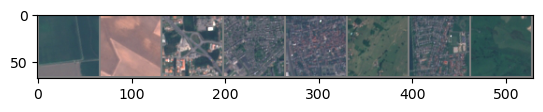

Predicted: AnnualCrop AnnualCrop AnnualCrop AnnualCrop AnnualCrop AnnualCrop AnnualCrop Forest


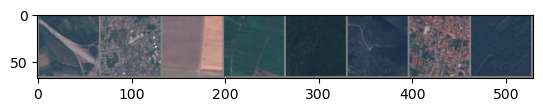

Predicted: Forest Residential PermanentCrop SeaLake Forest Forest Residential Forest


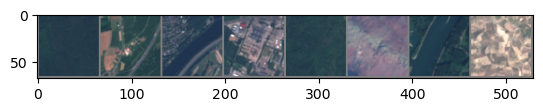

Predicted: SeaLake River River Residential SeaLake Residential SeaLake PermanentCrop


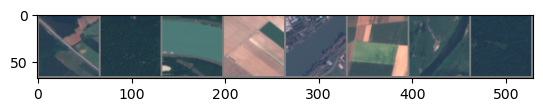

Predicted: Highway Forest SeaLake AnnualCrop Residential Highway Forest SeaLake


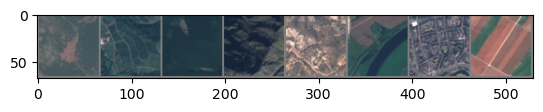

Predicted: Highway River Forest Forest Residential Forest Residential PermanentCrop


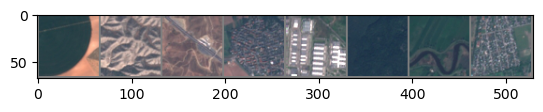

Predicted: HerbaceousVegetation HerbaceousVegetation PermanentCrop Residential Industrial SeaLake Pasture Residential


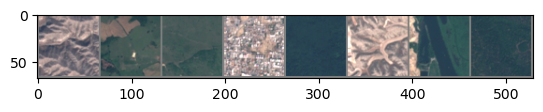

Predicted: PermanentCrop PermanentCrop Pasture Industrial SeaLake PermanentCrop Highway Forest


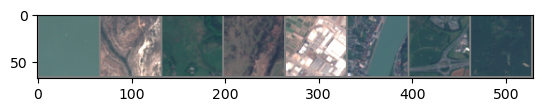

Predicted: SeaLake HerbaceousVegetation Pasture HerbaceousVegetation Industrial River River Forest


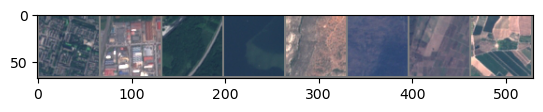

Predicted: Residential Industrial River SeaLake HerbaceousVegetation River Residential Highway


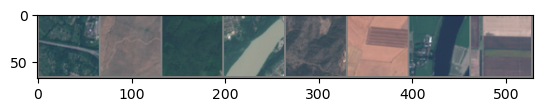

Predicted: Highway AnnualCrop Forest AnnualCrop HerbaceousVegetation AnnualCrop River PermanentCrop


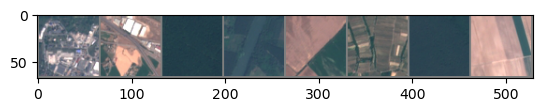

Predicted: Industrial Highway Forest SeaLake AnnualCrop PermanentCrop Forest AnnualCrop


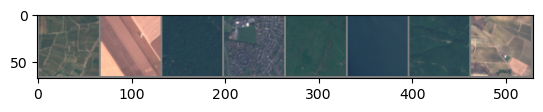

Predicted: HerbaceousVegetation AnnualCrop Forest Residential Pasture SeaLake Forest PermanentCrop


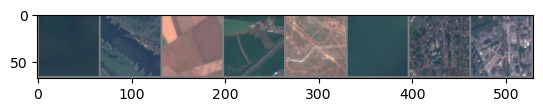

Predicted: Forest River AnnualCrop River PermanentCrop Pasture Residential Industrial


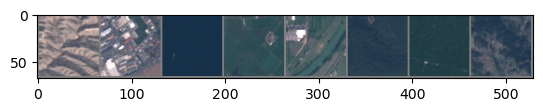

Predicted: PermanentCrop Industrial SeaLake Pasture River Forest Forest Highway


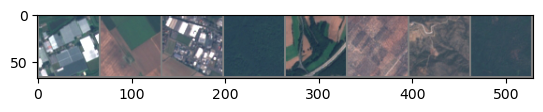

Predicted: Industrial AnnualCrop Industrial Forest AnnualCrop AnnualCrop HerbaceousVegetation Forest


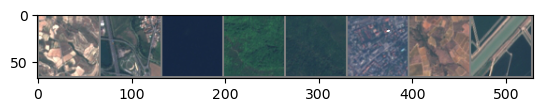

Predicted: PermanentCrop Residential SeaLake Pasture Forest Residential PermanentCrop River


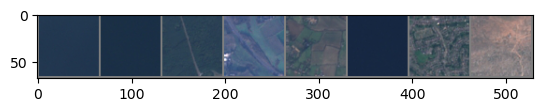

Predicted: SeaLake SeaLake Forest River HerbaceousVegetation SeaLake Highway HerbaceousVegetation
Epoch 1, Loss: 1.1530921058894614


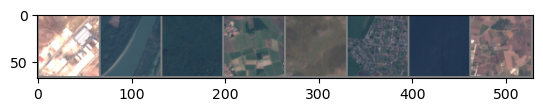

Predicted: Industrial River Forest PermanentCrop HerbaceousVegetation Residential SeaLake HerbaceousVegetation


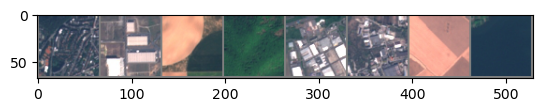

Predicted: Residential Industrial AnnualCrop Pasture Industrial Industrial AnnualCrop SeaLake


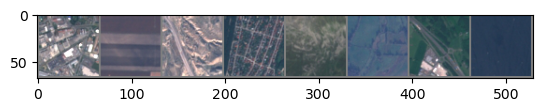

Predicted: Industrial HerbaceousVegetation Residential Residential HerbaceousVegetation Pasture Highway SeaLake


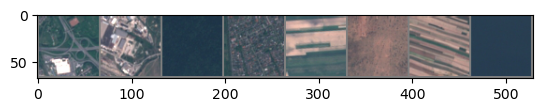

Predicted: Highway Industrial Forest Residential AnnualCrop AnnualCrop PermanentCrop SeaLake


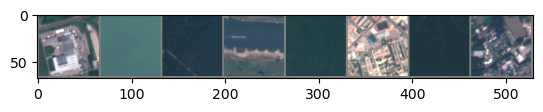

Predicted: Industrial SeaLake Forest River Forest Industrial Forest Highway


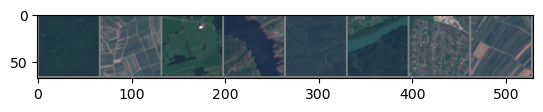

Predicted: Forest HerbaceousVegetation Pasture River Forest Forest Residential PermanentCrop


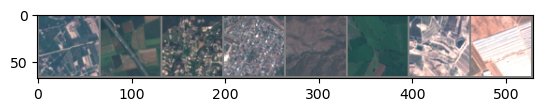

Predicted: River Highway Residential Residential HerbaceousVegetation Pasture Industrial Industrial


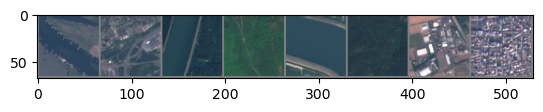

Predicted: River Residential Highway Forest River Forest Industrial Industrial


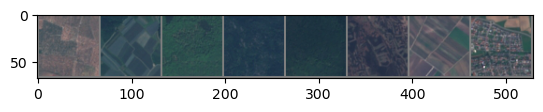

Predicted: HerbaceousVegetation River Pasture Forest Forest HerbaceousVegetation PermanentCrop HerbaceousVegetation


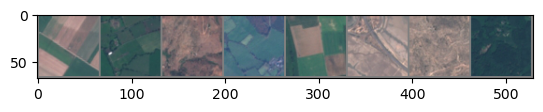

Predicted: AnnualCrop Pasture PermanentCrop SeaLake AnnualCrop PermanentCrop HerbaceousVegetation Forest


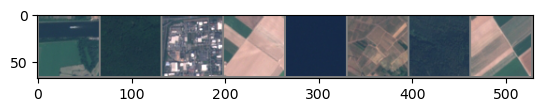

Predicted: River Forest Industrial AnnualCrop SeaLake HerbaceousVegetation Forest AnnualCrop


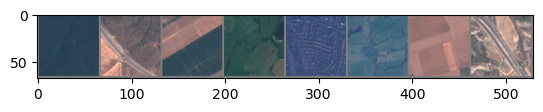

Predicted: Forest PermanentCrop AnnualCrop Pasture Residential Pasture AnnualCrop Highway


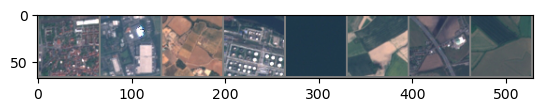

Predicted: Residential Industrial AnnualCrop Industrial SeaLake AnnualCrop Highway SeaLake


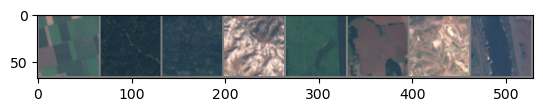

Predicted: AnnualCrop HerbaceousVegetation Forest PermanentCrop Pasture HerbaceousVegetation PermanentCrop River


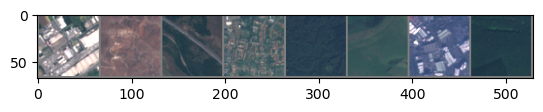

Predicted: Industrial HerbaceousVegetation Highway Residential Forest Pasture Industrial Forest


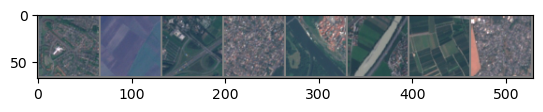

Predicted: Residential Highway Highway Residential Highway Highway Highway Residential


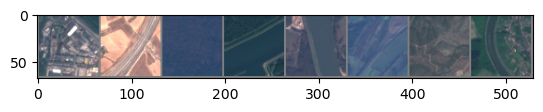

Predicted: Industrial Highway SeaLake River River Pasture HerbaceousVegetation River
Epoch 2, Loss: 0.6907187415474265


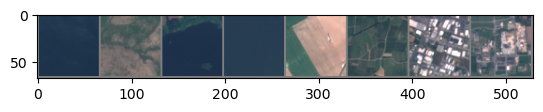

Predicted: SeaLake HerbaceousVegetation SeaLake SeaLake AnnualCrop HerbaceousVegetation Industrial Industrial


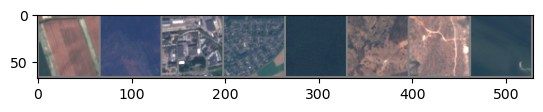

Predicted: PermanentCrop HerbaceousVegetation Industrial Highway Forest PermanentCrop PermanentCrop Forest


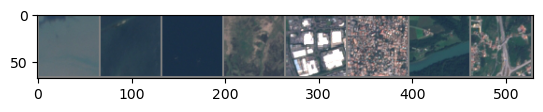

Predicted: SeaLake Forest SeaLake HerbaceousVegetation Industrial Residential River Highway


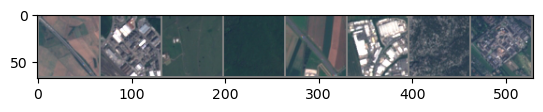

Predicted: Highway Industrial HerbaceousVegetation Forest Highway Industrial Residential Residential


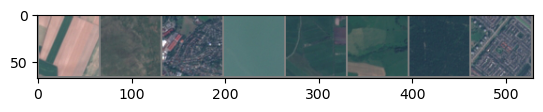

Predicted: AnnualCrop HerbaceousVegetation Residential SeaLake Pasture Pasture Forest Residential


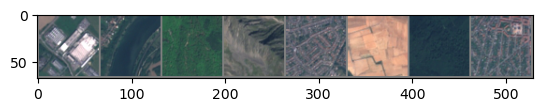

Predicted: Industrial River Forest HerbaceousVegetation Residential PermanentCrop Forest Residential


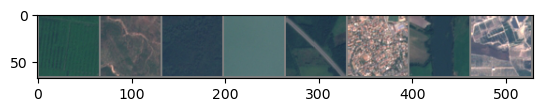

Predicted: Pasture HerbaceousVegetation Forest SeaLake Highway Residential River Industrial


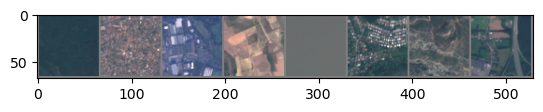

Predicted: Forest HerbaceousVegetation Industrial PermanentCrop SeaLake Residential HerbaceousVegetation Highway


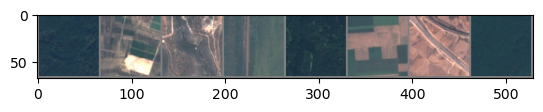

Predicted: Forest HerbaceousVegetation Residential AnnualCrop Forest AnnualCrop Highway Forest


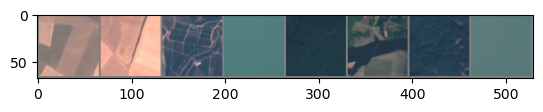

Predicted: AnnualCrop AnnualCrop River SeaLake Forest River Forest SeaLake


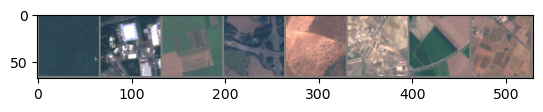

Predicted: Forest Industrial AnnualCrop Highway AnnualCrop PermanentCrop AnnualCrop PermanentCrop


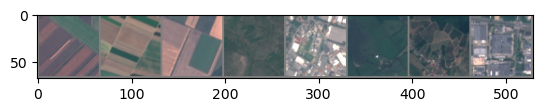

Predicted: AnnualCrop AnnualCrop AnnualCrop HerbaceousVegetation Industrial Pasture HerbaceousVegetation Industrial


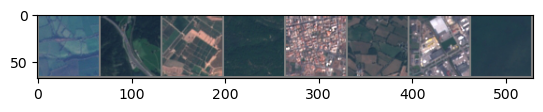

Predicted: Pasture River PermanentCrop Forest Residential HerbaceousVegetation Highway SeaLake


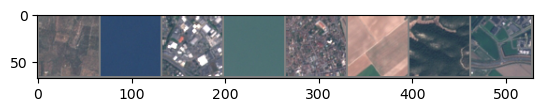

Predicted: PermanentCrop SeaLake Industrial SeaLake Residential AnnualCrop PermanentCrop River


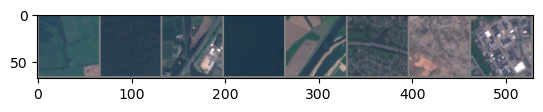

Predicted: River Forest Highway SeaLake Highway HerbaceousVegetation HerbaceousVegetation Industrial


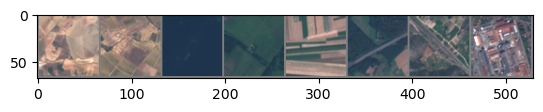

Predicted: PermanentCrop PermanentCrop SeaLake Pasture PermanentCrop Highway Highway Residential


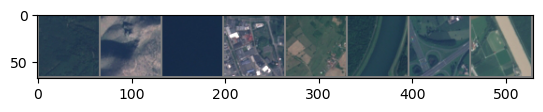

Predicted: Forest River SeaLake Industrial Pasture Forest Pasture River
Epoch 3, Loss: 0.5302604555907334


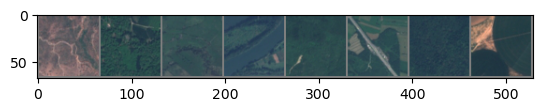

Predicted: HerbaceousVegetation Forest Pasture River Forest Highway Forest AnnualCrop


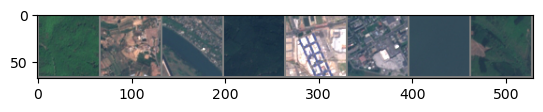

Predicted: Forest HerbaceousVegetation River Forest Industrial Industrial SeaLake Forest


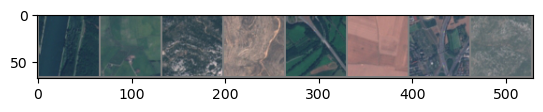

Predicted: River Pasture HerbaceousVegetation HerbaceousVegetation River AnnualCrop Highway HerbaceousVegetation


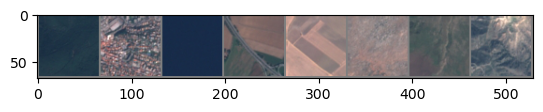

Predicted: Forest Residential SeaLake Highway AnnualCrop HerbaceousVegetation HerbaceousVegetation Highway


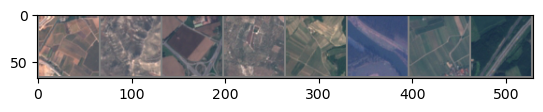

Predicted: PermanentCrop HerbaceousVegetation PermanentCrop HerbaceousVegetation PermanentCrop Highway PermanentCrop Highway


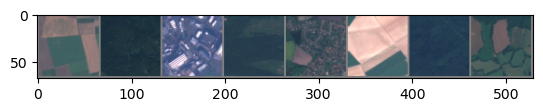

Predicted: AnnualCrop Forest Industrial Forest Residential AnnualCrop Forest Highway


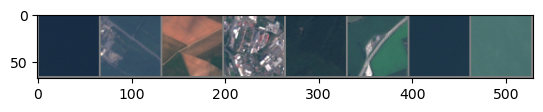

Predicted: SeaLake River AnnualCrop Industrial Forest River SeaLake SeaLake


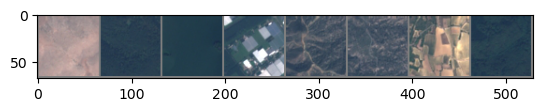

Predicted: AnnualCrop Forest SeaLake Industrial Highway HerbaceousVegetation PermanentCrop Forest


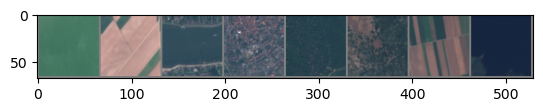

Predicted: SeaLake AnnualCrop River Residential Forest HerbaceousVegetation Pasture SeaLake


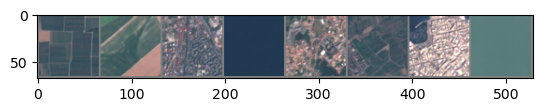

Predicted: River AnnualCrop Residential SeaLake Residential PermanentCrop Residential SeaLake


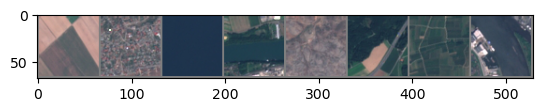

Predicted: AnnualCrop Residential SeaLake River HerbaceousVegetation Highway PermanentCrop River


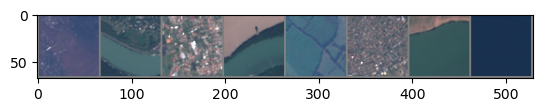

Predicted: HerbaceousVegetation River Industrial AnnualCrop Pasture Residential AnnualCrop SeaLake


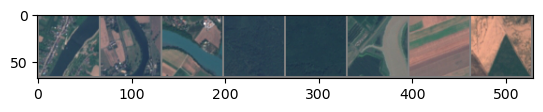

Predicted: Highway River River Forest Forest River AnnualCrop PermanentCrop


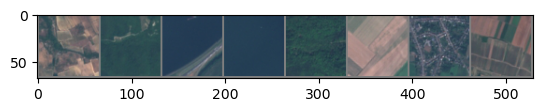

Predicted: PermanentCrop Pasture River SeaLake Pasture AnnualCrop Residential PermanentCrop


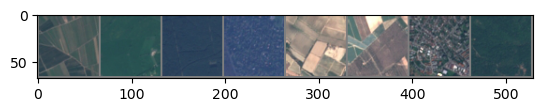

Predicted: Pasture Pasture Forest Residential PermanentCrop PermanentCrop Residential Forest


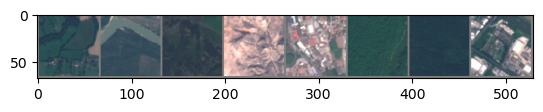

Predicted: Highway AnnualCrop HerbaceousVegetation Highway Industrial Pasture Forest Industrial


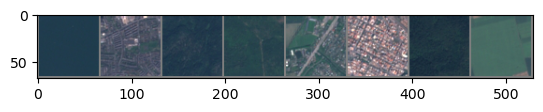

Predicted: SeaLake Residential Forest Forest Highway Residential Forest AnnualCrop
Epoch 4, Loss: 0.4315695252556067


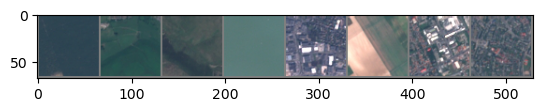

Predicted: Forest Pasture HerbaceousVegetation SeaLake Industrial Highway Industrial Residential


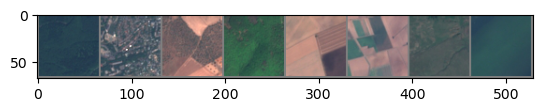

Predicted: Forest Residential Highway Forest AnnualCrop AnnualCrop HerbaceousVegetation SeaLake


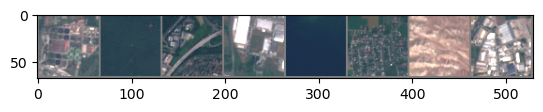

Predicted: Industrial Forest Highway Industrial SeaLake Residential PermanentCrop Industrial


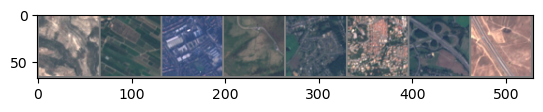

Predicted: PermanentCrop PermanentCrop Residential HerbaceousVegetation Highway Residential Highway Highway


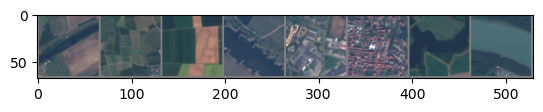

Predicted: PermanentCrop HerbaceousVegetation AnnualCrop Highway Residential Residential River River


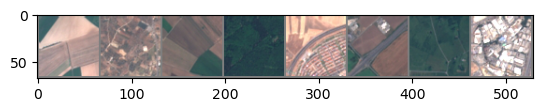

Predicted: PermanentCrop PermanentCrop AnnualCrop Forest Residential PermanentCrop Pasture Industrial


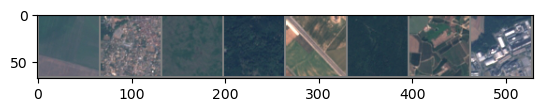

Predicted: AnnualCrop Residential Pasture Forest Highway Forest PermanentCrop Industrial


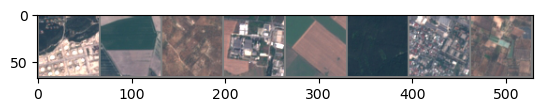

Predicted: Industrial AnnualCrop PermanentCrop Industrial AnnualCrop Forest Industrial PermanentCrop


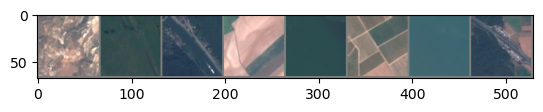

Predicted: HerbaceousVegetation Pasture River AnnualCrop SeaLake PermanentCrop SeaLake Highway


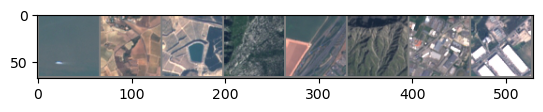

Predicted: SeaLake PermanentCrop River Residential Highway HerbaceousVegetation Industrial Industrial


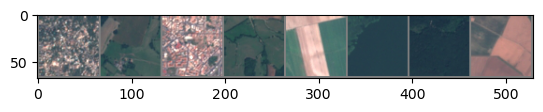

Predicted: Residential PermanentCrop Residential Pasture AnnualCrop Forest Forest AnnualCrop


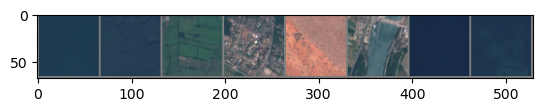

Predicted: SeaLake Forest Pasture Residential AnnualCrop PermanentCrop SeaLake SeaLake


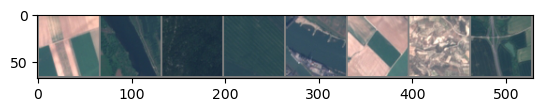

Predicted: AnnualCrop River Forest Forest River AnnualCrop HerbaceousVegetation River


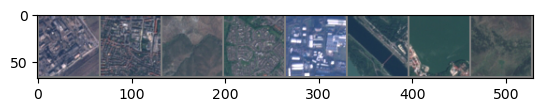

Predicted: Residential Residential HerbaceousVegetation Residential Industrial River Pasture HerbaceousVegetation


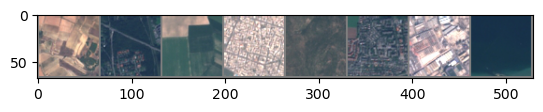

Predicted: PermanentCrop River AnnualCrop Residential HerbaceousVegetation Residential Industrial SeaLake


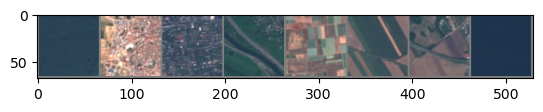

Predicted: Forest Residential Residential Highway PermanentCrop AnnualCrop Highway SeaLake


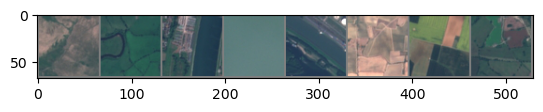

Predicted: PermanentCrop Pasture River SeaLake River Highway AnnualCrop Pasture
Epoch 5, Loss: 0.35582622259678925
Finished Training


In [6]:
# Number of training epochs
num_epochs = 5

testiter = iter(test_loader)
# Main training loop
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward, backward, and optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        if i % 20 == 0:
            with torch.no_grad():
                # Show a sample of images from the test data and model's predictions
                test_images, test_labels = testiter.__next__()
                test_images, test_labels = test_images.to(device), test_labels.to(device)

                imshow(torchvision.utils.make_grid(test_images[:8].cpu()))
                test_outputs = net(test_images[:8])
                _, predicted = torch.max(test_outputs, 1)
                # Map predicted indices to class labels
                predicted_labels = [dataset.classes[idx] for idx in predicted]
                
                print('Predicted:', ' '.join(predicted_labels))
                
    # Print average loss for the epoch
    print(f"Epoch {epoch+1}, Loss: {running_loss / (i+1)}")


print('Finished Training')

In [7]:
# Calculate accuracy score and confusion matrix after the training loop
net.eval()  # Set the model to evaluation mode

all_predictions = []
all_labels = []

with torch.no_grad():
    for data in test_loader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        
        outputs = net(inputs)
        _, predicted_indices = torch.max(outputs, 1)
        
        all_predictions.extend(predicted_indices.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Convert predicted indices to class labels
predicted_labels_1 = [dataset.classes[idx] for idx in all_predictions]
true_labels = [dataset.classes[label] for label in all_labels]

# Calculate accuracy score
test_accuracy = accuracy_score(true_labels, predicted_labels_1)

# Create confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels_1, labels=dataset.classes)

# Print accuracy score
print(f"Test Accuracy: {test_accuracy:.2f}")

# Print confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

Test Accuracy: 0.84
Confusion Matrix:
[[481   3   4  13   0  10  34   0  17  15]
 [  0 568   7   0   0  12   0   0   5   2]
 [  6  13 452  17   5  11  56  27  12   1]
 [ 12   0  17 370  17   7  48  15  38   0]
 [  0   0   7   4 481   0   1  13   0   0]
 [  6  18  10  10   0 315  24   0  19   1]
 [  7   0  54  27   5   7 374   9  14   0]
 [  0   0   5   4  13   0   5 564   0   0]
 [ 19   8   6  60   4  11  13   3 408   5]
 [  1  11   7   0   0   6   0   0   6 540]]


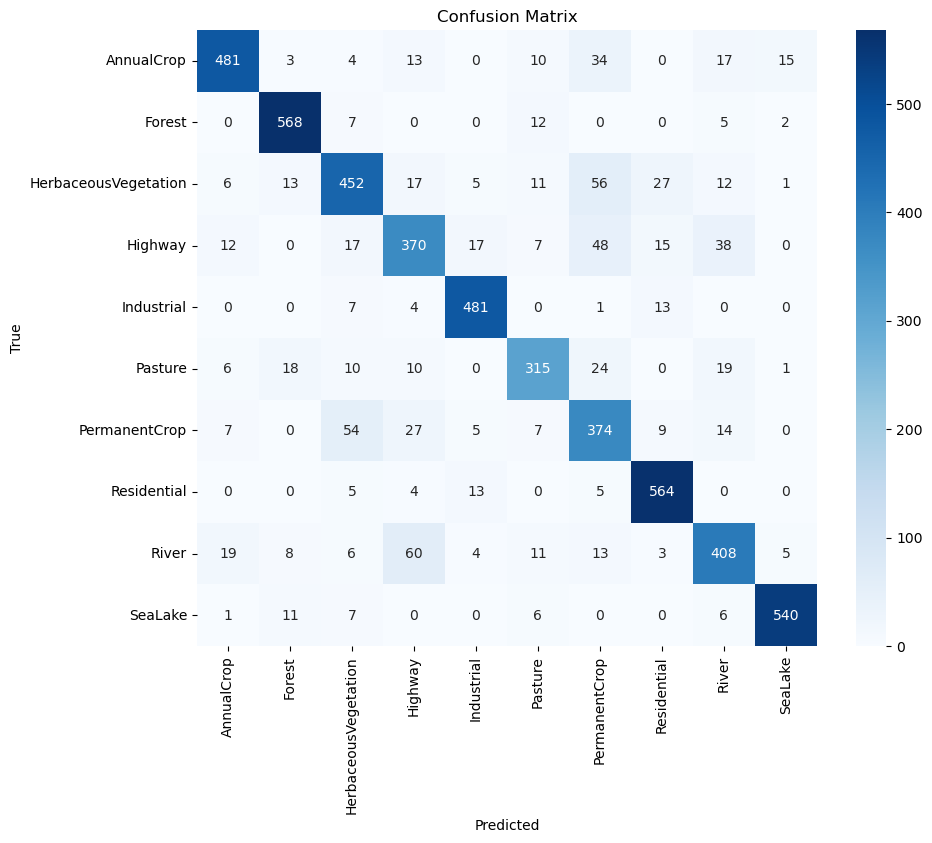

In [8]:
# Plot confusion matrix using seaborn and matplotlib
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=dataset.classes, yticklabels=dataset.classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

The overall model accuracy is 84%. It can be inferred from the confusion matrix heatmap that the model was very good in predicting *Residential*, *Forrest* and *Sealake* and poor in predicting *Highway*, *PermanentCrop* and *Pasture*. 